# Querying and plotting FROST SensorThingsAPI via Python

This notebook demonstrates how to query BGS sensor data with Python.  The API follows the OGC SensorThingsAPI standard and is provided by the FROST Server software.  Within Python, the `requests` library is used to query the API, then data are plotted using `pandas` and `matplotlib`.  Data are post-processed to remove outliers and apply a rolling mean.

#### Useful references

+ [FROST-Server documentation on Getting Data](https://fraunhoferiosb.github.io/FROST-Server/sensorthingsapi/3_GettingData.html)
+ [GeoPandas demo](https://nbviewer.jupyter.org/github/BritishGeologicalSurvey/geopandas-demo/blob/master/GeoPandas_demo.ipynb)
+ [Time series analysis with Pandas tutorial](https://github.com/volcan01010/python4geoscientists/blob/master/2_time_series_data.ipynb)
+ [Interactive Pandas tutorial](https://github.com/jvns/pandas-cookbook) (Click "launch binder", then work through the notebooks in the "cookbook" folder)

In [1]:
# Import the required libaries

import datetime as dt
import logging
from pprint import pprint
from typing import List, Dict, Optional  # Typing is optional in Python but helps with documentation and code editors
from warnings import warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

logging.basicConfig(level=logging.INFO)

In [2]:
# Define a function that queries the API

BASE_URL = "https://sensors.bgs.ac.uk/FROST-Server/v1.1/"

def query_api(entity: str, params: Optional[Dict]=None) -> List[Dict]:
    """
    Query FROST API and return values. Queries are logged, errors raise exceptions
    and data are paged if they don't all fit in a single response.
    """  
    # Query API
    response = requests.get(BASE_URL + entity, params=params)
    logging.info(f'query_api request: {response.url}')
    response.raise_for_status()  # throw error on bad query
    
    # Store results
    response_json = response.json()
    data = response_json['value']
    
    # Loop over pages. get() returns None, which is "falsey", if nextLink doesn't exist.
    while next_link := response_json.get('@iot.nextLink'):
        response = requests.get(next_link)
        logging.info(f'query_api request: {response.url}')
        response.raise_for_status()  # throw error on bad query
        
        response_json = response.json()
        data.extend(response_json['value'])

    return data

## List of all the boreholes

This example demonstrates a query to the API to fetch data on the boreholes.  The API returns JSON data, which can be read into a Pandas dataframe.

In [3]:
# Make a request to API
json_data = query_api('FeaturesOfInterest', params={"$filter": "properties/type eq 'BOREHOLE'"})
pprint(json_data[0])  # Uncomment this line to see example response

INFO:root:query_api request: https://sensors.bgs.ac.uk/FROST-Server/v1.1/FeaturesOfInterest?%24filter=properties%2Ftype+eq+%27BOREHOLE%27


{'@iot.id': 2,
 '@iot.selfLink': 'https://sensors.bgs.ac.uk/FROST-Server/v1.1/FeaturesOfInterest(2)',
 'Observations@iot.navigationLink': 'https://sensors.bgs.ac.uk/FROST-Server/v1.1/FeaturesOfInterest(2)/Observations',
 'description': 'UKGEOS GGA09R',
 'encodingType': 'application/geo+json',
 'feature': {'coordinates': [-4.20130691940609, 55.8381723708354],
             'type': 'Point'},
 'name': 'UKGEOS GGA09R',
 'properties': {'borehole_id': 1487524,
                'drilled_length': 16.0,
                'publish_yn': 'Y',
                'reference': 'GGA09R',
                'reference_type': 'UKGEOS',
                'sen_id': 9,
                'sobi_bgs_id': 20693604,
                'type': 'BOREHOLE'}}


In [6]:
# Pandas can read json data and normalize nested fields
boreholes = pd.json_normalize(json_data)
boreholes.set_index('properties.sobi_bgs_id', inplace=True)

print(boreholes.loc[:, ['description', 'properties.drilled_length']])

                          description  properties.drilled_length
properties.sobi_bgs_id                                          
20693604                UKGEOS GGA09R                      16.00
20693605                 UKGEOS GGB04                      16.00
20693603                 UKGEOS GGA08                      91.37
20693598                UKGEOS GGA03R                      41.72
20693599                 UKGEOS GGA04                      53.63
20693606                 UKGEOS GGB05                      46.00
20693602                 UKGEOS GGA07                      56.90
20693596                 UKGEOS GGA01                      52.00
20693601                UKGEOS GGA06R                      16.00
20693600                 UKGEOS GGA05                      88.50


In [7]:
# Print all info for a given borehole
print(boreholes.loc[20693604])

description                                                            UKGEOS GGA09R
encodingType                                                    application/geo+json
@iot.id                                                                            2
name                                                                   UKGEOS GGA09R
@iot.selfLink                      https://sensors.bgs.ac.uk/FROST-Server/v1.1/Fe...
Observations@iot.navigationLink    https://sensors.bgs.ac.uk/FROST-Server/v1.1/Fe...
feature.type                                                                   Point
feature.coordinates                            [-4.20130691940609, 55.8381723708354]
properties.type                                                             BOREHOLE
properties.sen_id                                                                  9
properties.reference                                                          GGA09R
properties.publish_yn                                            

## Plotting time series data

A Datastream provides an entry point for a time series of Observations and hold the metadata that relate to the readings.  SensorThingsAPI allows Datastreams to be selected by the Thing that records them, the model of Sensor that was used and the Observed Property being measured.

Using the `expand=Observations` parameter in the query allows the observation data to be returned.

In [14]:
# Here we define functions used for post-processing the datastreams.  Data are converted to 
# Pandas Series objects.

def parse_datastream(datastream: Dict) -> Dict:
    """
    Extract simplified information from datastream response, including converting
    observations data to Pandas Series and removing outliers.
    """
    data = {'name': datastream['name'],
            'description': datastream['description'],
            'unit_name': datastream['unitOfMeasurement']['name'],
            'unit_symbol':  datastream['unitOfMeasurement']['symbol'],
            'observations': convert_observations_to_series(datastream['Observations'])
           }
    data['observations'] = remove_outliers(data['observations'])
    return data


def convert_observations_to_series(observations: List[Dict]) -> pd.Series:
    """
    Convert observations data into Pandas Series with time-based indexing.
    """
    if len(observations) == 34050:
        warn("Observations count matches maximum for $top (34050) - paging may be required.")

    observation_tuples = [(pd.to_datetime(item['phenomenonTime']), item['result'])
                          for item in observations]
    timestamp, result = zip(*observation_tuples)

    return pd.Series(result, index=timestamp)


def remove_outliers(data: pd.Series) -> pd.Series:
    """
    Replace values with Z-score (number of standard deviations away from mean) greater
    than 3 with NaN.
    """
    zscore = abs((data - data.mean()) / data.std())
    data.loc[zscore > 3] = np.nan
    return data

### All the readings from a single Thing

This example plots all the data collected by a single (corresponding to a sensor instrument or data logger).  This can show the relationship between different observed properties.  The plots are displayed in the notebook and also saved to the current working directory.

#### Results

All readings except pressure are remarkably steady.  There is a correlation between Salinity, Conductivity and TDS.

In [15]:
# Query
# The parameters for an expanded entity in a query should be ; separated
observations_params = ';'.join(("$select=phenomenonTime,result",
                                "$filter=phenomenonTime gt 2021-04-01T00:00:00+00:00",
                                "$orderby=phenomenonTime asc",
                                "$top=34050"
                              ))
json_data = query_api('Things(3)/Datastreams', params={"$expand": f"Observations({observations_params})"})
# pprint(json_data[0])  # Uncomment this line to see example response, which includes all observations

INFO:root:query_api request: https://sensors.bgs.ac.uk/FROST-Server/v1.1/Things(3)/Datastreams?%24expand=Observations%28%24select%3DphenomenonTime%2Cresult%3B%24filter%3DphenomenonTime+gt+2021-04-01T00%3A00%3A00%2B00%3A00%3B%24orderby%3DphenomenonTime+asc%3B%24top%3D34050%29


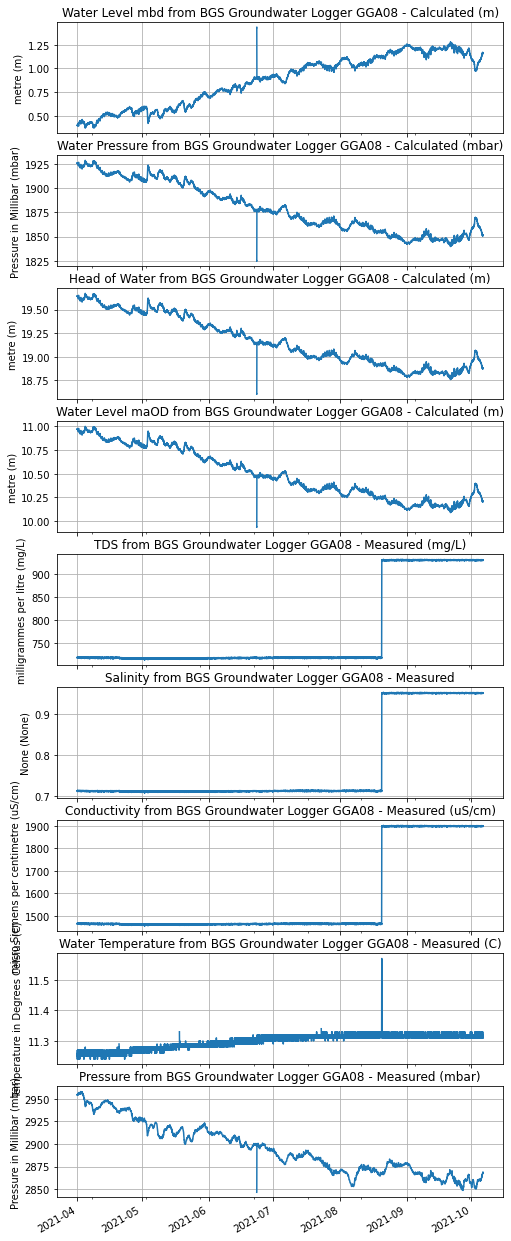

In [16]:
fig, axs = plt.subplots(nrows=len(json_data), sharex=True, figsize=(8, 24))

for i, datastream in enumerate(json_data):
    ax = axs[i]
    data = parse_datastream(datastream)
    data['observations'].plot(ax=ax)
    ax.grid()
    ax.set_ylabel(f"{data['unit_name']} ({data['unit_symbol']})")
    ax.set_title(datastream['description'])

fig.savefig('Logger GGA08.png', facecolor="white", bbox_inches="tight")

### All the readings from a single ObservedProperty (Temperature)

This example plots all the data for the same ObservedProperty across all sensors.  This can show how readings vary across different boreholes.  A rolling mean filter was applied to these data to smooth out instrument noise.  The plots are displayed in the notebook and also saved to the current working directory.

#### Results

All readings are very similar (11°C) and steady.

In [17]:
# Query
# The parameters for an expanded entity in a query should be ; separated
observations_params = ';'.join(("$select=phenomenonTime,result",
                                "$filter=phenomenonTime gt 2021-04-01T00:00:00+00:00",
                                "$orderby=phenomenonTime asc",
                                "$top=34050"
                              ))
json_data = query_api('ObservedProperties(3)/Datastreams', params={"$expand": f"Observations({observations_params})"})
# pprint(json_data[0])  # Uncomment this line to see example response, which includes all observations

INFO:root:query_api request: https://sensors.bgs.ac.uk/FROST-Server/v1.1/ObservedProperties(3)/Datastreams?%24expand=Observations%28%24select%3DphenomenonTime%2Cresult%3B%24filter%3DphenomenonTime+gt+2021-04-01T00%3A00%3A00%2B00%3A00%3B%24orderby%3DphenomenonTime+asc%3B%24top%3D34050%29


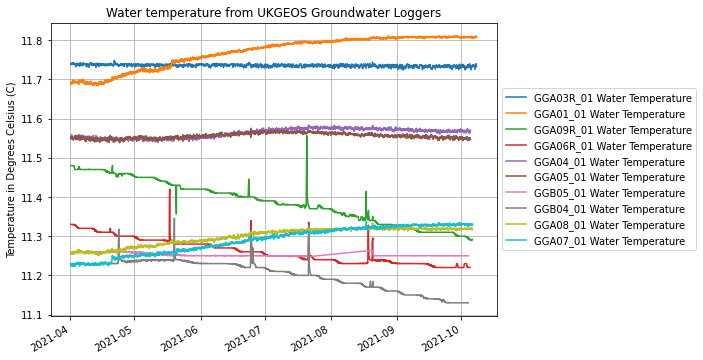

In [18]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))

for i, datastream in enumerate(json_data):
    data = parse_datastream(datastream)
    # Data are noisy so we smooth by applying a rolling mean filter
    smoothed = data['observations'].rolling(window=24).mean()
    smoothed.dropna(inplace=True)
    smoothed.plot(ax=ax, label=data['name'])

ax.grid()
ax.set_ylabel(f"{data['unit_name']} ({data['unit_symbol']})")
ax.set_title("Water temperature from UKGEOS Groundwater Loggers")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig('water_temperature.png', facecolor="white", bbox_inches="tight")